In [12]:
import scipy
import numpy as np
import json
import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import os
from scipy.signal import convolve
from analysis_pkg.tools.util import normalize

In [13]:
def load_bpod_data(dpath):
    with open(dpath, 'r') as file:
        data = json.load(file)
    return data

def take_closest(ms_stamps, bpod_stamps):
    """
    Assumes ms_stamps is sorted. Returns closest stamps to the given bpod_stamps.

    If two numbers are equally close, return the smallest number.
    """
    msAlignedIndex = []
    for bpod_stamp in bpod_stamps:
        pos = bisect_left(ms_stamps, bpod_stamp)
        if pos == 0:
            return ms_stamps[0]
        if pos == len(ms_stamps):
            return ms_stamps[-1]
        before = ms_stamps[pos - 1]
        after = ms_stamps[pos]
        if after - bpod_stamp < bpod_stamp - before:
            msAlignedIndex.append(np.where(ms_stamps ==after))
        else:
            msAlignedIndex.append(np.where(ms_stamps ==before))
    return np.squeeze(np.array(msAlignedIndex))
    
def get_state_time(state, bpod_data, trialnumbers=None):
    """
    Input a state name and bpod_data. Return the time stamp of the state(relative to trial start)
    """
    onsets = []
    offsets = []
    if trialnumbers:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            onsets.append(np.array(trial['States'][state]).flatten()[0])
            offsets.append(np.array(trial['States'][state]).flatten()[1])
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            onsets.append(np.array(trial['States'][state]).flatten()[0])
            offsets.append(np.array(trial['States'][state]).flatten()[1])
    return np.array(onsets), np.array(offsets)
    
def get_RPE_neuron_activities(trialRewards, calcium_activities, calcium_baselines=None):
    """Select RPE relative neurons using the method from Muller. 2024 """
    if not calcium_baselines:
        calcium_baselines = np.zeros(calcium_activities.shape)
    RPE_neurons = []
    RPE_neurons_id = []
    for i, singleNeuronActivity in enumerate(calcium_activities):
        trialRewards_constant = sm.add_constant(trialRewards)
        model = sm.OLS(singleNeuronActivity, trialRewards_constant).fit()
        if model.pvalues[1] < 0.05:
            # print(singleNeuronActivity)
            # print(calcium_baselines[i])
            # print(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons.append(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons_id.append(i)
    return np.array(RPE_neurons), np.array(RPE_neurons_id)

def z_score(data, axis=1):
    return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)

def mean_across_events(events, raw_neural_activities, fps=30, duration=2):  
    sum_acitivities = np.zeros((raw_neural_activities.shape[0],fps*duration*2))
    for event in events:
        raw_neural_activities_cue_onset = np.array(raw_neural_activities[:, event-duration*fps:event+duration*fps])
        sum_acitivities = raw_neural_activities_cue_onset + sum_acitivities
    return sum_acitivities/len(events)

def create_raised_cosine_basis(n_basis, window_length_frames, dt=1):
    """
    Create a set of raised cosine basis functions over a specified window (in frames).

    Parameters:
      n_basis             : int
          Number of basis functions.
      window_length_frames: int or float
          Duration (in frames) over which to define the basis functions.
      dt                  : int or float, optional
          Time resolution. For frame-based data, dt=1 (one frame per step).

    Returns:
      t         : 1D numpy array
          The frame vector spanning the window.
      basis_set : 2D numpy array of shape (n_basis, len(t))
          Each row corresponds to one raised cosine basis function.
    """
    # Create a vector of frame indices over the window.
    t = np.arange(0, window_length_frames, dt)
    
    # Determine centers for each basis function, evenly spaced over the window.
    centers = np.linspace(0, window_length_frames, n_basis)
    
    # Choose a width for the basis functions.
    # The width controls how broad each function is. You can adjust the scaling factor as needed.
    width = (window_length_frames / (n_basis - 1)) * 1.5  # 1.5 is an adjustable scaling factor.
    
    basis_set = []
    for center in centers:
        # Compute the argument for the cosine, then clip it so that it only has nonzero values over a finite interval.
        cosine_arg = np.clip((t - center) * np.pi / width, -np.pi, np.pi)
        basis = (np.cos(cosine_arg) + 1) / 2  # Scale to range [0,1]
        
        # Optionally zero out values outside a window centered on the current basis function.
        basis[t < (center - width/2)] = 0
        basis[t > (center + width/2)] = 0
        
        basis_set.append(basis)
    
    return t, np.array(basis_set)

def poisson_deviance(y, mu):
    """
    Compute the deviance for Poisson data.
    
    Parameters:
      y  : array of observed counts
      mu : array of predicted counts (should be > 0)
      
    Returns:
      The deviance value.
    """
    # Use np.where to avoid computing log(0); when y==0, treat y*log(y/mu) as 0.
    term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)
    return 2 * np.sum(term)

In [14]:
mouse = 'ZZ0024-LR'
date = '2024-08-16' # Remember to laod corresponding bpod data
date_in_bpod = date.replace("-", "")
### load wavesurfer stamps
ms_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_ms.mat")['ms_frames_samplingstamps'])
bpod_trialstart_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_bpod.mat")['bpod_trialstart_samplingstamps'])

### load bpod results
bpod_data = load_bpod_data(glob.glob(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/{mouse}/*{mouse}*{date_in_bpod}*')[0])
trialRewards = np.array(bpod_data["SessionData"]['TrialRewards'])

### Exclude wrong trials
wrongTrials = []
for i, trial in enumerate(bpod_data['SessionData']['RawEvents']['Trial']):
    if trial['States']['WrongPort'][0]:
        wrongTrials.append(i)
trialRewards = np.delete(trialRewards, wrongTrials)

### load minian results
minian_results = xr.open_dataset(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/minian_data/{mouse}_{date}.netcdf")

### load caliai results
calcium_traces_caliali = scipy.io.loadmat(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/caliali_data/{mouse}_{date_in_bpod}_C.mat')
calcium_traces_caliali = list(calcium_traces_caliali.values())[-1]

spikes_caliali = scipy.io.loadmat(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/caliali_data/{mouse}_{date_in_bpod}_S.mat')
spikes_caliali = list(spikes_caliali.values())[-1]

In [15]:
BASELINE_WND_DURATION = 0.5
ACTIVITY_WND_DURATION = 2.5
FS = 20000


### Handle sessions during which the wavesurfer crashed
if len(bpod_trialstart_stamps) < 40:
    for i in range(len(bpod_trialstart_stamps), 40):
        next_stamp = bpod_trialstart_stamps[i-1] + bpod_data['SessionData']['RawEvents']['Trial'][i-1]['States']['EndState'][1] * FS
        bpod_trialstart_stamps = np.append(bpod_trialstart_stamps, next_stamp)
        
bpod_trialstart_stamps = np.delete(bpod_trialstart_stamps, wrongTrials)

if (len(minian_results.frame) - len(ms_stamps)) >= 150:
    for i in range(len(ms_stamps), len(minian_results.frame)):
        next_stamp = ms_stamps[i-1] + int(FS/30)
        ms_stamps = np.append(ms_stamps, next_stamp)

In [16]:
drinkOn, drinkOff = get_state_time('Drinking', bpod_data)

In [ ]:
temporal_downsample = 2

calcium_traces = np.array(minian_results.C)
spikes = np.array(minian_results.S)

rewardTimes,_ = get_state_time('Reward', bpod_data)
trialEnds,_ = get_state_time('EndState', bpod_data)

ws_rewardTimes = (rewardTimes)*FS + bpod_trialstart_stamps
ms_rewardTimes = (take_closest(ms_stamps[::2], ws_rewardTimes)).astype(int)

ws_trialEnds = (trialEnds)*FS + bpod_trialstart_stamps
ms_trialEnds = (take_closest(ms_stamps, ws_trialEnds)/temporal_downsample).astype(int)

ms_trialstarts = (take_closest(ms_stamps, bpod_trialstart_stamps)/temporal_downsample).astype(int)


In [48]:
ms_trialEnds

array([  859,  1058,  1312,  1548,  1747,  1948,  2163,  2480,  2594,
        2703,  2894,  3070,  3261,  3897,  4220,  4464,  4653,  4778,
        4958,  5164,  5489,  5675,  5957,  6112,  6295,  6485,  6746,
        7038,  7176,  9690, 10962, 11291, 11547, 11853, 12074, 12234,
       12450, 12756, 12990, 13278])

In [51]:
ms_trialEnds_v2 = (np.searchsorted(ms_stamps[::2], ws_trialEnds))
ms_trialEnds_v2

array([  860,  1059,  1313,  1548,  1748,  1949,  2163,  2481,  2595,
        2704,  2895,  3071,  3262,  3897,  4221,  4464,  4654,  4779,
        4959,  5164,  5490,  5676,  5957,  6113,  6295,  6486,  6747,
        7039,  7177,  9691, 10963, 11292, 11548, 11853, 12075, 12235,
       12451, 12757, 12990, 13278])

In [45]:
(np.searchsorted(ms_stamps[::2], bpod_trialstart_stamps))

array([  350,   862,  1061,  1315,  1550,  1750,  1950,  2165,  2482,
        2596,  2706,  2896,  3073,  3264,  3899,  4222,  4466,  4656,
        4781,  4960,  5166,  5492,  5678,  5959,  6115,  6297,  6488,
        6749,  7041,  7179,  9693, 10965, 11294, 11550, 11855, 12077,
       12237, 12453, 12759, 12993])

In [40]:
ms_stamps[::2].shape

(13558,)

In [52]:
ms_rewardTimes_v2 = (np.searchsorted(ms_stamps[::2], ws_rewardTimes))

In [30]:
rewardTimes

array([ 28.2042,   9.0809,  12.2097,   8.7625,   8.178 ,   8.4863,
         8.1172,  13.6313,   6.3587,   6.0782,   6.4914,   6.5252,
         9.4123,  31.9654,  15.1531,   7.8724,   6.9504,   6.3935,
         7.3113,   7.3201,  11.0344,   7.4099,  10.7804,   9.0282,
         6.8189,   6.5146,  16.107 ,  18.6524,   6.7029, 166.5862,
        78.4628,  20.7879,  13.3562,  10.4627,  11.7335,   6.7002,
         6.6025,  12.5893,  10.4681,   9.949 ])

In [53]:
ms_rewardTimes_v2

array([  770,   997,  1242,  1445,  1672,  1876,  2071,  2368,  2577,
        2687,  2803,  2994,  3213,  3740,  4125,  4340,  4570,  4751,
        4890,  5069,  5331,  5602,  5838,  6094,  6216,  6394,  6728,
        7027,  7140,  9659, 10861, 11275, 11493, 11706, 12030, 12177,
       12335, 12640, 12915, 13141])

In [34]:
ms_rewardTimes

array([  770,   996,  1242,  1445,  1671,  1875,  2071,  2367,  2576,
        2686,  2802,  2993,  3212,  3739,  4124,  4339,  4569,  4750,
        4889,  5069,  5330,  5601,  5837,  6093,  6215,  6393,  6727,
        7026,  7140,  9659, 10860, 11274, 11492, 11705, 12029, 12176,
       12334, 12640, 12914, 13140])

In [75]:
sum = 0
drinkDurations = []
for i in range(40):
    drinktimes = np.array(bpod_data['SessionData']['RawEvents']['Trial'][i]['States']['Drinking']).flatten()
    drinkDuration = drinktimes[1]-drinktimes[0]
    drinkDurations.append(drinkDuration)
drinkDurations = np.array(drinkDurations)

In [76]:
np.median(drinkDurations)

2.5448499999999994

In [77]:
### Get binary reward onset matrix
reward_binary = np.zeros((spikes_caliali.shape[1],1))
for i, ms_rewardTime in enumerate(ms_rewardTimes):
    reward_binary[ms_rewardTime] = trialRewards[i]

In [78]:
### Get port encoded in one hot encode
trialPorts = bpod_data['SessionData']['TrialTypes']
port_onehot = np.zeros((calcium_traces.shape[1],8))

for i, trialPort in enumerate(trialPorts):
    port_onehot[ms_trialstarts[i]:ms_trialEnds[i],trialPort-1] = 1

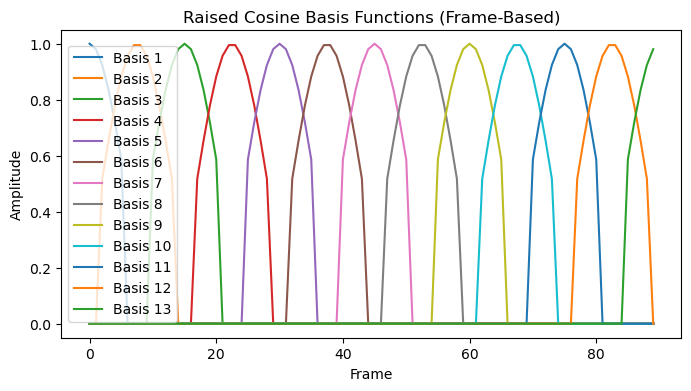

In [79]:
n_basis = 13             # Number of basis functions
window_length_frames = 90  # For example, a window of 30 frames (which is 1 second at 30 fps)
dt = 1                   # Since the data is frame-based, each unit represents one frame

# Create the basis functions
t, basis_set = create_raised_cosine_basis(n_basis, window_length_frames, dt)

# Plot the basis functions
plt.figure(figsize=(8, 4))
for i in range(n_basis):
    plt.plot(t, basis_set[i], label=f'Basis {i+1}')
plt.xlabel('Frame')
plt.ylabel('Amplitude')
plt.title('Raised Cosine Basis Functions (Frame-Based)')
plt.legend()
plt.show()

### Smooth binary reward onset using exponential decay function
tau = 90
kernel_length = int(6 * tau)
if kernel_length % 2 == 0:
    kernel_length += 1  # ensure odd length for symmetry

# Create the kernel over 0 to kernel_length frames.
t_kernel = np.arange(kernel_length)
exp_kernel = np.exp(-t_kernel / tau)
reward_smoothed = convolve(reward_binary.flatten(), exp_kernel, mode='full')[:reward_binary.shape[0]].reshape(-1,1)

### Create intercept matrix
intercept = np.ones((spikes_caliali.shape[1], 1))

### Stack all the matrices above to get final design matrix
design_matrix = np.hstack([intercept, reward_smoothed])

In [80]:
design_matrix.shape

(13557, 2)

In [81]:
calcium_traces.shape

(71, 27112)

### GLM from Harvey

In [82]:
# import numpy as np
# import scipy.stats
# from sklearn.model_selection import train_test_split, GroupShuffleSplit
# import tensorflow as tf
# import matplotlib
# import matplotlib.pyplot as plt
# import glm_class as glm


# X_data = design_matrix
# Y_data = calcium_traces
# n_neurons = calcium_traces.shape[0]
# all_neuron_fde = np.zeros(n_neurons)
# folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/'
# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# for neuron_idx, neuron_trace in enumerate(calcium_traces):
#     # Reset keras states
#     tf.keras.backend.clear_session()

#     # Initialize GLM_CV (here I'm listing out all input arguments, but many of them can be left with default values)
#     model_cv = glm.GLM_CV(n_folds = 5, auto_split = True, split_by_group = False, split_random_state = 42,
#                         activation = 'linear', loss_type = 'gaussian', 
#                         regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(3, -6, 10), 
#                         l1_ratio = 0., smooth_strength = 0., 
#                         optimizer = 'adam', learning_rate = 1e-2, momentum = 0.5, 
#                         min_iter_per_lambda = 100, max_iter_per_lambda = 10**4, 
#                         num_iter_check = 100, convergence_tol = 1e-6)
#     model_cv.fit(X_data, neuron_trace, verbose=False)
#     # Select the model using 1SE rule and given minimal lambda
#     model_cv.select_model(se_fraction = 1, min_lambda = 1e-5, make_fig = False)
#     fold_fde = model_cv.selected_frac_dev_expl_cv
#     all_neuron_fde[neuron_idx] = np.mean(fold_fde)
#     print(f"Neuron{neuron_idx} fitted")

# np.save(os.path.join(folder_path, "all_neuron_fde_Harvey.npy"), all_neuron_fde)


In [92]:
spikes

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [83]:
sm.add_constant(reward_smoothed).shape

(13557, 2)

In [93]:
spikes_caliali

<393x13557 sparse matrix of type '<class 'numpy.float64'>'
	with 24877 stored elements in Compressed Sparse Column format>

### GLM from statsmodel

In [101]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pickle

# -------------------------------
# Set parameters for demonstration.
# Replace these with your actual design matrix and response data.
n_frames = spikes_caliali.shape[1]        # total number of frames in the session
n_predictors = 2       # e.g., intercept + 8 port condition columns + reward regressor
n_neurons = spikes_caliali.shape[0]         # number of neurons

# For demonstration purposes, create dummy data.
# For Poisson regression, the response must be nonnegative integers.
np.random.seed(42)
X_data = sm.add_constant(reward_smoothed)  # Your actual design matrix
#Y_data = calcium_traces  # Simulated count data
Y_data = spikes_caliali.toarray()  # Simulated count data
# -------------------------------
# 10-Fold Cross Validation for performance evaluation (Poisson GLM)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
all_neuron_r2 = np.zeros(n_neurons)

# Initialize an array to store the cross-validated fraction deviance explained (FDE) for each neuron.
all_neuron_fde = np.zeros(n_neurons)

# Loop over neurons
for neuron_idx in range(n_neurons):
    y_neuron = Y_data[neuron_idx, :]  # Get the count data for this neuron (length = n_frames)
    fold_fde = []
    
    # Iterate through the 10 folds.
    for train_index, test_index in kf.split(X_data):
        X_train, X_test = X_data[train_index, :], X_data[test_index, :]
        print(y_neuron.shape)
        y_train, y_test = y_neuron[train_index], y_neuron[test_index]
        
        # Fit the Poisson GLM (default link is log).
        model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
        try:
            result = model.fit()
        except Exception as e:
            print(f"Skipping neuron {neuron_idx} due to error: {e}")
            continue

        # Predict the expected counts on the test set.
        y_pred = result.predict(X_test)
        
        # Compute the deviance of the fitted model on the test set.
        dev_model = poisson_deviance(y_test, y_pred)
        
        # Compute the null deviance.
        # Here we use the mean of the training data as the prediction for all test observations.
        y_null = np.full_like(y_test, np.mean(y_train))
        dev_null = poisson_deviance(y_test, y_null)
        
        # Compute the fraction of deviance explained for this fold.
        # (Check that dev_null is not zero to avoid division by zero.)
        fde = 1 - dev_model / dev_null if dev_null != 0 else np.nan
        fold_fde.append(fde)
    
    # Average the FDE values over the 10 folds for this neuron.
    all_neuron_fde[neuron_idx] = np.mean(fold_fde)
    print(f"Neuron{neuron_idx} fitted")

# Report the cross-validated fraction deviance explained for each neuron.
print("5-fold cross-validated Fraction Deviance Explained (FDE) for each neuron:")
# print(all_neuron_fde)

# Optionally, compute the overall mean FDE across neurons.
mean_fde = np.mean(all_neuron_fde)
print("Overall mean Fraction Deviance Explained:", mean_fde)

final_models = {}

for neuron_idx in range(n_neurons):
    y_neuron = Y_data[neuron_idx, :]
    model = sm.GLM(y_neuron, X_data, family=sm.families.Poisson())
    try:
        result = model.fit()

        # Option 1: Use statsmodels' built-in save method
        filename = f'neuron_{neuron_idx}_glm_model.pkl'
        folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        result.save(os.path.join(folder_path,filename))
        print(f"Saved model for neuron {neuron_idx} to {filename}")
    except Exception as e:
        print(f"Skipping neuron {neuron_idx} due to error: {e}")
        continue
    if result:
        final_models[neuron_idx] = result

with open(os.path.join(folder_path,"all_neuron_glm_models.pkl"), "wb") as f:
    pickle.dump(final_models, f)
print("Saved all neuron models to all_neuron_glm_models.pkl")

np.save(os.path.join(folder_path, "all_neuron_fde.npy"), all_neuron_fde)
np.save(os.path.join(folder_path, 'RPE_relative_neuron_id.npy'), np.where(all_neuron_fde > 0.2)[0])

(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron0 fitted
(13557,)


/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_86774/2471452808.py:129: RuntimeWarning: divide by zero encountered in log
  term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)
/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_86774/2471452808.py:129: RuntimeWarning: invalid value encountered in multiply
  term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)


(13557,)
(13557,)
(13557,)
(13557,)
Neuron1 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron2 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron3 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron4 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron5 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron6 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron7 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron8 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron9 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron10 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron11 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron12 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron13 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron14 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron15 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron16 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557

/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(13557,)
Neuron278 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron279 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron280 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron281 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron282 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron283 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron284 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron285 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron286 fitted
(13557,)
(13557,)
Skipping neuron 287 due to error: The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.
(13557,)
(13557,)
(13557,)
Neuron287 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron288 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron289 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron290 fitted
(13557,)
(13557,)
(13557,)
(13557,)
(13557,)
Neuron291 fitted
(13557,)
(13557,)


In [57]:
all_models = sm.load(f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/all_neuron_glm_models.pkl')

In [61]:
reward_binary.shape

(31863, 1)

In [62]:
spikes.mean(axis=0).shape

(31863,)

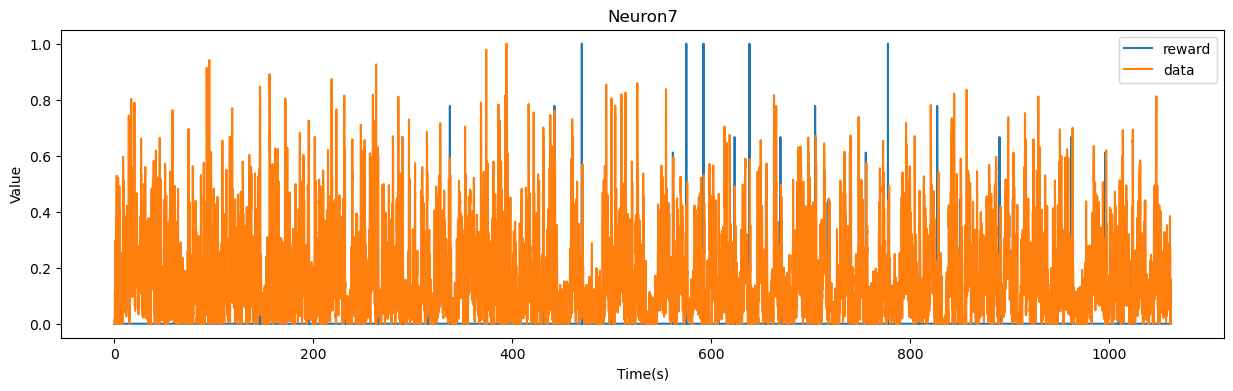

In [64]:
time = np.arange(calcium_traces.shape[1])/30
time = np.arange(reward_binary.shape[0])/30
plt.figure(figsize=(15, 4))
plt.plot(time, normalize(reward_binary), label='reward')
plt.plot(time, normalize(spikes.mean(axis=0)), label='data')
plt.xlabel('Time(s)')
plt.ylabel('Value')
plt.title(f'Neuron{7}')
plt.legend()
plt.show()

In [257]:
all_neuron_fde[23]

0.29380273506695487

In [16]:
np.where(reward_binary>0)

(array([ 4394,  5858,  6941,  7948,  8684,  9464, 10119, 10584, 12645,
        12934, 13271, 14097, 14981, 15596, 15941, 16843, 17247, 17766,
        18212, 18704, 19151, 19648, 20084, 21130, 21538, 22180, 22659,
        23327, 24256, 24811, 25497, 25975, 26691, 27092, 27673, 28853,
        29881, 30284, 30666, 31043]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

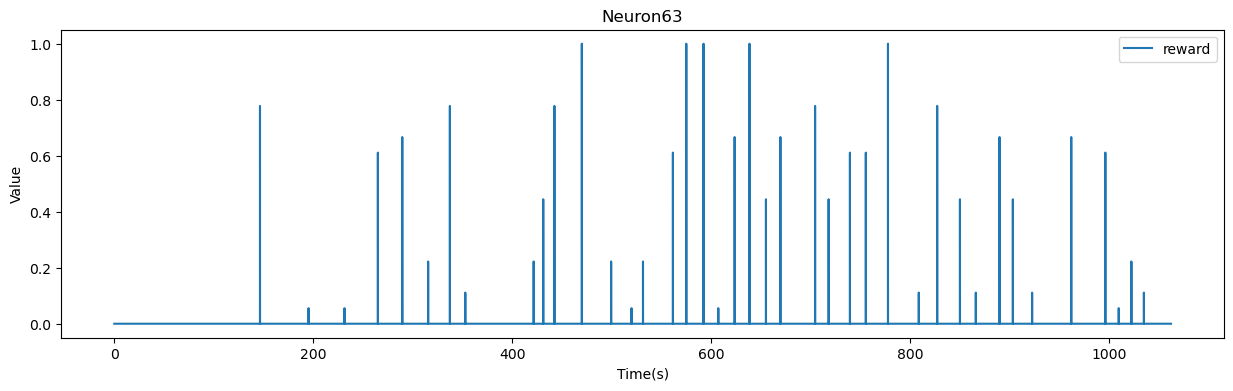

In [65]:
time = np.arange(calcium_traces.shape[1])/30
# time = np.arange(1000)/30
plt.figure(figsize=(15, 4))
plt.plot(time, normalize(reward_binary), label='reward')
plt.xlabel('Time(s)')
plt.ylabel('Value')
plt.title(f'Neuron{neuron_idx}')
plt.legend()
plt.show()

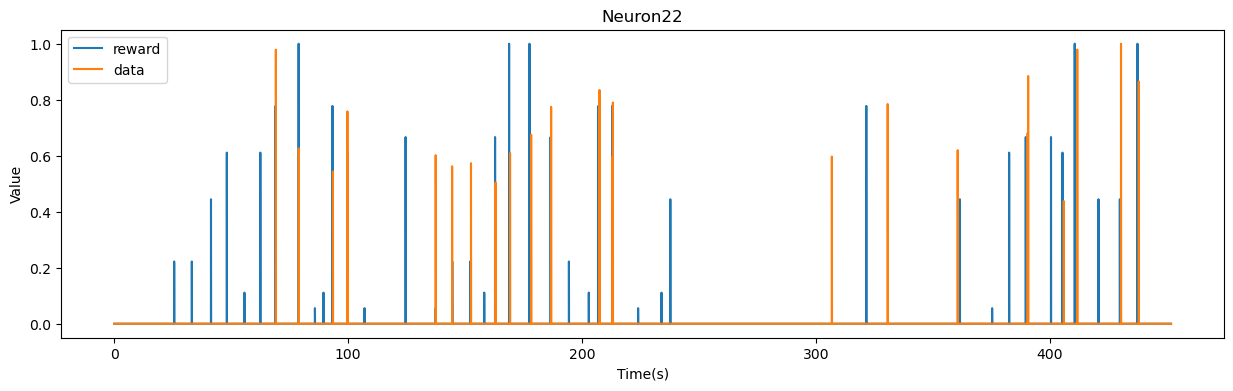

In [102]:
all_neuron_fde = np.load(f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/all_neuron_fde.npy')
for neuron_idx in np.where(all_neuron_fde > 0.2)[0]:
    time = np.arange(spikes_caliali.shape[1])/30
    # time = np.arange(1000)/30
    plt.figure(figsize=(15, 4))
    plt.plot(time, normalize(reward_binary), label='reward')
    plt.plot(time, normalize(spikes_caliali.toarray()[neuron_idx,:]), label='data')
    plt.xlabel('Time(s)')
    plt.ylabel('Value')
    plt.title(f'Neuron{neuron_idx}')
    plt.legend()
    plt.show()

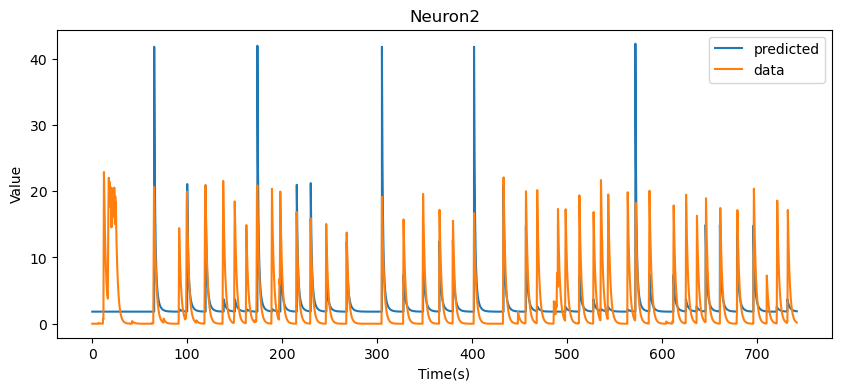

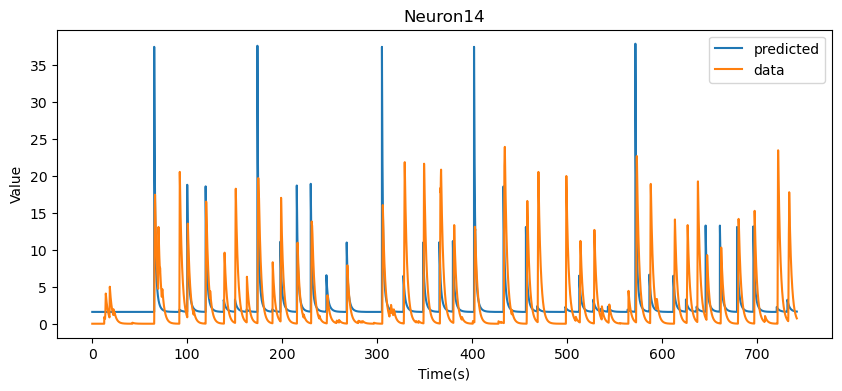

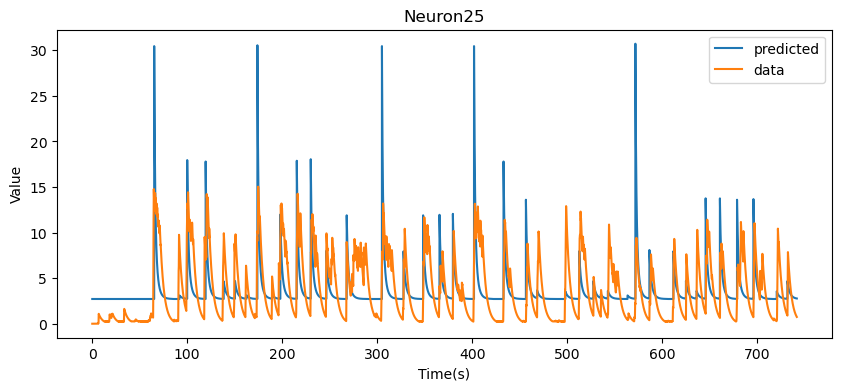

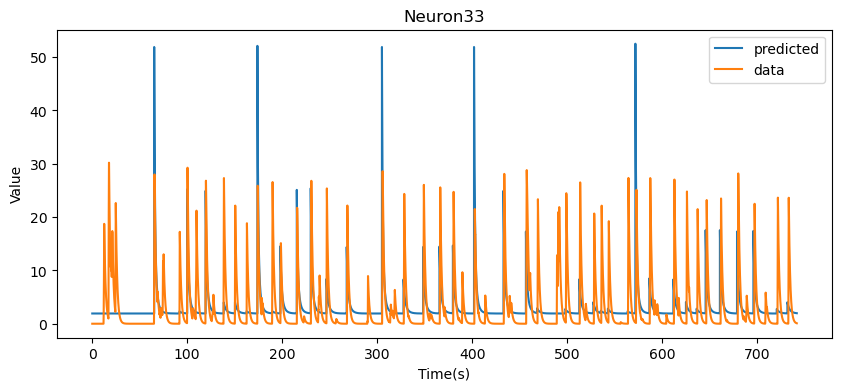

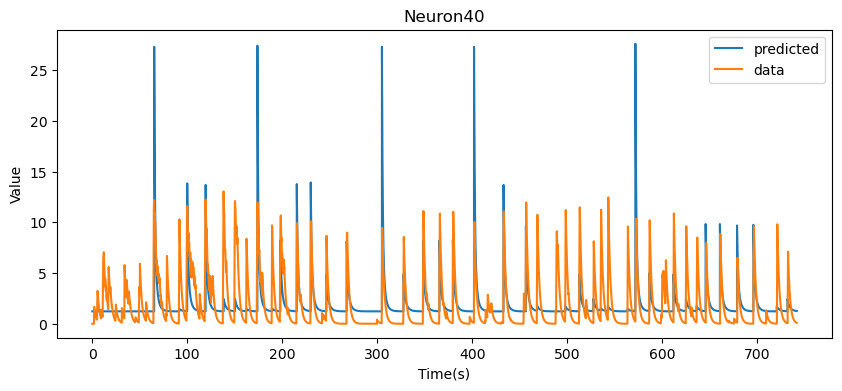

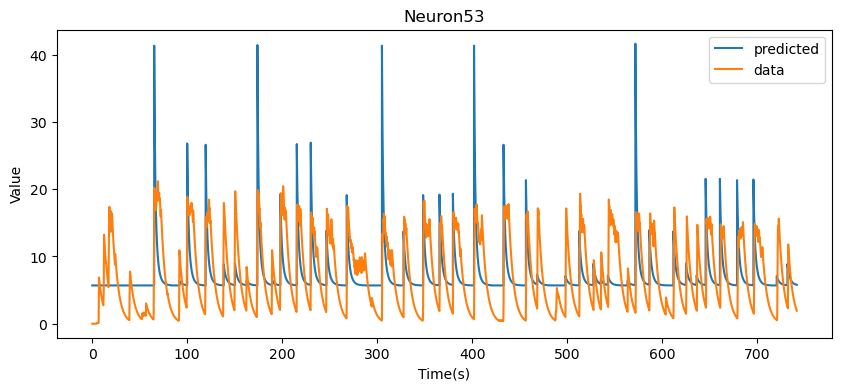

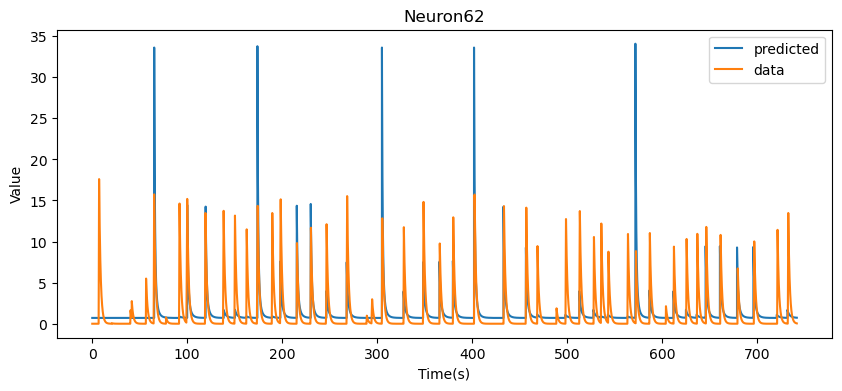

In [22]:
all_neuron_fde = np.load('')
for neuron_idx in np.where(all_neuron_fde > 0.2)[0]:
    time = np.arange(n_frames)/30
    plt.figure(figsize=(10, 4))
    plt.plot(time, all_models[neuron_idx].predict(design_matrix), label='predicted')
    plt.plot(time, calcium_traces[neuron_idx,:], label='data')
    plt.xlabel('Time(s)')
    plt.ylabel('Value')
    plt.title(f'Neuron{neuron_idx}')
    plt.legend()
    plt.show()